# Unity ML Tennis with Proximal Policy Optimization (PPO)

## Collaboration and Competition: Multi-Agent RL

Multi-Agent Reinforcement Learning (MARL) involves multiple agents learning to interact within a shared environment. It's used in diverse areas like robotics, autonomous vehicles, and gaming. Key challenges in MARL include handling non-stationarity, credit assignment among agents, effective communication, and scalability.

Proximal Policy Optimization (PPO) is often chosen for MARL due to its simplicity, sample efficiency, and balance in exploration and exploitation. PPO is adaptable for both cooperative and competitive multi-agent scenarios, making it suitable for environments like the Unity Tennis environment, where agents can learn collaboratively. Its robustness and stable learning process help manage the complexities inherent in MARL.

## Multi-agent Proximal Policy Optimization (MAPPO)

As mentioned above, Proximal Policy Optimization (PPO) is a widely used reinforcement learning algorithm known for its stability and effectiveness, especially in environments with continuous action spaces. PPO belongs to the family of policy gradient methods, offering a balance between sample efficiency and ease of implementation.

### **Multi-Agent Scenario:**

In a multi-agent scenario, like the Tennis environment from Unity, PPO can be applied with some considerations:

1. **Independent Observations**: Each agent receives its own observation from the environment. In the Tennis environment, observations are tailored for each agent, meaning that each agent's perspective is already considered. This setup simplifies the process as there's no need for additional modifications to handle different perspectives.
2. **Rewards Relative to Agent**: Each agent receives rewards relative to its actions and state, independent of the other agents. This is ideal for the Tennis environment, where each agent's reward is calculated based on its performance, and not directly on the other agent's actions. This approach aligns well with PPO's objective of maximizing the expected return.


All this means that we can use one policy and one critic network for both agents, and train them as if it was a batch with multiple agents (2 in this case) playing separate gammes.


# Overview of the Agent Architecture

In the realm of Multi-Agent Reinforcement Learning (MARL), the provided Python program delineates an intricate agent architecture tailored for environments where multiple agents interact, learn, and make decisions concurrently. This architecture is underpinned by the Actor-Critic model, a staple in reinforcement learning, which is augmented for handling multiple agents efficiently.

### The Actor-Critic Model

1. **Actor Network**: The Actor network, a crucial component of the architecture, is responsible for generating actions given the current state. It consists of three fully connected layers. The first two layers apply the ReLU activation function for non-linearity, while the final layer employs the tanh function to output action values within a specific range, usually [-1, 1]. This structure ensures a balance between expressiveness and computational efficiency.
2. **Critic Network**: Parallel to the Actor, the Critic network estimates the value of the current state, guiding the Actor's decisions. It mirrors the Actor's structure with three fully connected layers and ReLU activations, outputting a scalar value representing the state's value.
3. **ActorCritic Class**: This class unifies the Actor and Critic networks, creating a cohesive model that outputs both action distributions (from the Actor) and state values (from the Critic). The standard deviation for the action distribution is also adjustable, providing a knob for tuning the exploration-exploitation trade-off.

### The Agent Class

1. **Initialization**: The Agent class initializes with the number of agents, state and action sizes, and various hyperparameters like learning rate, optimizer epsilon, weight decay, and more. It creates an instance of the ActorCritic model and sets up an optimizer (Adam in this case) for learning.
2. **Acting and Learning**:
    - The **`act`** method enables the agent to select actions based on the current state, using the ActorCritic model. It returns the chosen actions, their log probabilities, and the corresponding state values.
    - The **`learn`** method facilitates the agent's learning from experiences. It uses batches of experiences to update the model's weights using the Proximal Policy Optimization (PPO) algorithm, which involves several epochs of mini-batch updates.

### Key Characteristics

- **Multi-Agent Compatibility**: This architecture is adept at handling scenarios involving multiple agents, a fundamental aspect of complex environments like the Unity Tennis environment.
- **Flexibility and Scalability**: The use of neural networks offers flexibility in learning various tasks, and the parameterization allows scalability to different problem sizes and complexities.
- **Balance of Exploration and Exploitation**: The use of a stochastic policy (through the normal distribution in action selection) allows for both exploration of the state space and exploitation of learned policies.

In summary, this agent architecture is a comprehensive, adaptable framework for tackling complex MARL problems, leveraging the strengths of the Actor-Critic approach and PPO algorithm.

In [1]:
""" This code is a composition of the following sources: 
- Udacity DRLND PPO exercise
- Bonniesjli PPO-Reacher_UnityML: https://github.com/bonniesjli/PPO-Reacher_UnityML.git
- My own implementation and mods based on the PPO paper and on the class"""
# Agent and models
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# from PPO import ppo_loss

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x)) # still the same, since the range is [-1.0, +1.0]
    
    
class Critic(nn.Module):
    def __init__(self, state_size, value_size=1, hidden_size=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, value_size)
        
    def forward(self, states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, value_size=1, hidden_size=64, std=0.0):
        super(ActorCritic, self).__init__()
        self.actor = Actor(state_size, action_size, hidden_size)
        self.critic = Critic(state_size, value_size, hidden_size)
        
        self.log_std = nn.Parameter(torch.ones(1, action_size)*std)
        
    def forward(self, states):
        obs = torch.FloatTensor(states)
        
        # Critic
        values = self.critic(obs)
        
        # Actor
        mu = self.actor(obs)
        std = self.log_std.exp().expand_as(mu)
        dist = torch.distributions.Normal(mu, std)
        
        return dist, values
    

class Agent():
    def __init__(self, num_agents, state_size, action_size,
                 LR=3.e4,
                 op_epsilon=1.e-5,
                 weight_decay=1.e-4,
                 batch_size=32,
                 sgd_epochs=4,
                 gradient_clip=5,
                 std=0.1,
                 value_size=1,
                 hidden_size=64,
                 clip_epsilon=0.1,
                 c1=0.5,
                 beta=0.01):
        
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gradient_clip = gradient_clip
        self.lr = LR
        self.model = ActorCritic(state_size, action_size, value_size=value_size, hidden_size=hidden_size, std=std)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR, weight_decay=weight_decay, eps=op_epsilon)
        # self.optimizer = optim.Adam(self.model.parameters(), lr=LR, eps=op_epsilon)
        
        self.sgd_epochs = sgd_epochs
        self.clip_epsilon = clip_epsilon
        self.c1 = c1
        self.beta = beta
        
        self.model.train()
        
    def act(self, states):
        """Remember: states are state vectors for each agent
        It is used when collecting trajectories
        """
        dist, values = self.model(states) # pass the state trough the network and get a distribution over actions and the value of the state
        actions = dist.sample() # sample an action from the distribution
        log_probs = dist.log_prob(actions) # calculate the log probability of that action
        log_probs = log_probs.sum(-1).unsqueeze(-1) # sum the log probabilities of all actions taken (in case of multiple actions) and reshape to (batch_size, 1)
        
        return actions, log_probs, values
    
    def learn(self, states, actions, log_probs_old, returns, advantages, sgd_epochs=4):
        """ Performs a learning step given a batch of experiences
        
        Remmeber: in the PPO algorithm, we perform SGD_episodes (usually 4) weights update steps per batch
        using the proximal policy ratio clipped objective function
        """        

        num_batches = states.size(0) // self.batch_size
        for i in range(self.sgd_epochs):
            batch_count = 0
            batch_ind = 0
            for i in range(num_batches):
                sampled_states = states[batch_ind:batch_ind+self.batch_size, :]
                sampled_actions = actions[batch_ind:batch_ind+self.batch_size, :]
                sampled_log_probs_old = log_probs_old[batch_ind:batch_ind+self.batch_size, :]
                sampled_returns = returns[batch_ind:batch_ind+self.batch_size, :]
                sampled_advantages = advantages[batch_ind:batch_ind+self.batch_size, :]
                
                L = ppo_loss(self.model, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages,
                             clip_epsilon=self.clip_epsilon, c1=self.c1, beta=self.beta)
                
                self.optimizer.zero_grad()
                (L).backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip)
                self.optimizer.step()
                
                batch_ind += self.batch_size
                batch_count += 1


# PPO Loss

PPO is a policy gradient method that seeks to update policies in a way that avoids large and potentially harmful policy updates. Let's break down the key components of this function:

1. **Probability Ratios**: The function starts by calculating the probability ratio **`r(θ) = π(a|s) / π_old(a|s)`**, where **`π(a|s)`** is the probability of taking action **`a`** in state **`s`** under the current policy, and **`π_old(a|s)`** is the probability under the old policy. This is computed by exponentiating the difference between the new and old log probabilities of the actions.
2. **Advantages**: The **`advantages`** parameter represents the advantage estimates A(s,a), which indicate how much better an action is compared to the average. They are used to scale the policy ratio.
3. **Objective Function**: The objective function in PPO, **`L_CPI(θ) = r(θ) * A`**, is a product of the probability ratio and the advantages. This function encourages the policy to increase the probability of actions that lead to higher than expected returns.
4. **Clipping**: To avoid large policy updates, PPO introduces a clipping mechanism. The policy ratio is clipped within the range **`[1 - ε, 1 + ε]`**, where ε is a small value (**`clip_epsilon`** in this code). The final objective is the minimum of the unclipped and clipped objectives.
5. **Entropy Regularization**: Entropy regularization (**`beta * entropy.mean()`**) is added to the loss to encourage exploration by discouraging the policy from becoming too deterministic.
6. **Value Loss**: The value loss **`L_VF(θ) = (V(s) - V_t)^2`** is a mean squared error term between the predicted state values (**`values`**) and the returns. This encourages the critic to accurately predict the expected returns. The coefficient **`c1`** adjusts the importance of this term in the total loss.
7. **Total Loss**: The total loss is the sum of the policy loss and the value loss. The policy loss is computed as the negative of the minimum between the clipped and unclipped objectives minus the entropy regularization term. The negative sign ensures that maximizing the objective function corresponds to minimizing the loss.

In [2]:
import torch

# Loss function. NOT INTEGRATED YET
def ppo_loss(model, states, actions, log_probs_old, returns, advantages, clip_epsilon=0.1, c1=0.5, beta=0.01):
    dist, values = model(states)
    
    log_probs = dist.log_prob(actions)
    log_probs = torch.sum(log_probs, dim=1, keepdim=True)
    entropy = dist.entropy().mean()
    
    # r(θ) =  π(a|s) / π_old(a|s)
    ratio = (log_probs - log_probs_old).exp() # NOTE WHYYYYYYY????
    
    # Surrogate Objctive : L_CPI(θ) = r(θ) * A
    obj = ratio * advantages 
    
    # clip ( r(θ), 1-Ɛ, 1+Ɛ )*A
    obj_clipped = ratio.clamp(1.0 - clip_epsilon, 1.0 + clip_epsilon) * advantages
    
    # L_CLIP(θ) = E { min[ r(θ)A, clip ( r(θ), 1-Ɛ, 1+Ɛ )*A ] - β * KL }
    policy_loss = -torch.min(obj, obj_clipped).mean(0) - beta * entropy.mean() # NOTE: WHY ARE WE TAKING THE MEAN AGAIN???
    
    # L_VF(θ) = ( V(s) - V_t )^2
    value_loss = c1 * (returns - values).pow(2).mean()
    
    return policy_loss + value_loss

# Generalized Advantage Estimation

The **`calculate_advantages`** function in this code calculates the Generalized Advantage Estimation, and is designed to evaluate how beneficial each action taken by the agent is, compared to an average action, in the context of a reinforcement learning environment. It processes a series of states, actions, and rewards (referred to as a "rollout") and performs the following steps:

1. **Temporal Difference (TD) Error Calculation**: For each state in the rollout, it calculates the TD error, which is the difference between the predicted value of the current state and the combined reward and predicted value of the next state.
2. **Advantage Estimation**: Using the TD errors, the function computes the 'advantage' for each state. The advantage is a measure of how much better an action is compared to the average action at a given state. It uses Generalized Advantage Estimation (GAE) for a balance between bias and variance in these estimates.
3. **Normalization**: The advantages are normalized (adjusted to have a mean of zero and a unit standard deviation) to improve learning stability.
4. **Return Processed Data**: Finally, the function returns the processed data (states, actions, and their respective advantages), which are used to update the agent's policy.


In [3]:
def calculate_advantages(rollout, returns, num_agents, gamma=0.99, tau=0.95):
    """ Given a rollout, calculates the advantages for each state """
    num_steps = len(rollout) - 1
    processed_rollout = [None] * num_steps
    advantages = torch.zeros((num_agents, 1))

    for i in reversed(range(num_steps)):
        states, value, actions, log_probs, rewards, dones = map(lambda x: torch.Tensor(x), rollout[i])
        next_value = rollout[i + 1][1]

        dones = dones.unsqueeze(1)
        rewards = rewards.unsqueeze(1)

        # Compute the updated returns
        returns = rewards + gamma * dones * returns

        # Compute temporal difference error
        td_error = rewards + gamma * dones * next_value.detach() - value.detach()
        
        advantages = advantages * tau * gamma * dones + td_error
        processed_rollout[i] = [states, actions, log_probs, returns, advantages]

    # Concatenate along the appropriate dimension
    states, actions, log_probs_old, returns, advantages = map(lambda x: torch.cat(x, dim=0), zip(*processed_rollout))
    
    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    return states, actions, log_probs_old, returns, advantages

In [4]:
""" This code is a composition of the following sources: 
- Udacity DRLND PPO exercise
- Bonniesjli PPO-Reacher_UnityML: https://github.com/bonniesjli/PPO-Reacher_UnityML.git
- My own implementation and mods based on the PPO paper and on the class"""
import numpy as np
from collections import deque
import torch
from src.utils import test_agent
import os
from PPO import calculate_advantages
from agent import Agent
from unityagents import UnityEnvironment
import numpy as np
import time
import copy

def collect_trajectories(env, brain_name, agent, max_t):
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    states = env_info.vector_observations
        
    rollout = []
    agents_rewards = np.zeros(num_agents)
    episode_rewards = []

    for s in range(max_t):
    # s = 0
    # while True:
        actions, log_probs, values = agent.act(states)
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards 
        dones = np.array([1 if t else 0 for t in env_info.local_done])
        agents_rewards += rewards

        for j, done in enumerate(dones):
            if dones[j]:
                episode_rewards.append(agents_rewards[j])
                agents_rewards[j] = 0

        rollout.append([states, values.detach(), actions.detach(), log_probs.detach(), rewards, 1 - dones])
        # s += 1
        states = next_states
        # if np.any(dones):                                        # exit loop if episode finished
        #     l_s = s
        
    # print(f"Last step: {l_s}.")

    pending_value = agent.model(states)[-1]
    returns = pending_value.detach() 
    rollout.append([states, pending_value, None, None, None, None])
    
    return rollout, returns, episode_rewards, np.mean(episode_rewards)


def train(env, brain_name, agent, num_agents, n_episodes, max_t, gamma=0.99, tau=0.95, run_name="testing_02", save_path=".."):
    print(f"Starting training...")
    time.sleep(2)
    env.info = env.reset(train_mode = True)[brain_name]
    all_scores = []
    all_scores_window = deque(maxlen=100)
    best_so_far = 0.0
    best_so_far_ep = 0
    for i_episode in range(n_episodes):
        # Each iteration, N parallel actors collect T time steps of data
        rollout, returns, _, _ = collect_trajectories(env, brain_name, agent, max_t)
        
        states, actions, log_probs_old, returns, advantages = calculate_advantages(rollout, returns, num_agents, gamma=gamma, tau=tau)
        # print(f"States: {states.shape}. Actions: {actions.shape}. Log_probs_old: {log_probs_old.shape}. Returns: {returns.shape}. Advantages: {advantages.shape}")
        agent.learn(states, actions, log_probs_old, returns, advantages)
        
        test_mean_reward = test_agent(env, agent, brain_name)

        all_scores.append(test_mean_reward)
        all_scores_window.append(test_mean_reward)      
        
        if (i_episode + 1) % 20 == 0:
            
            if np.mean(all_scores_window) > best_so_far:
                
                if not os.path.isdir(f"{save_path}/ckpt/{run_name}/"):
                    os.mkdir(f"{save_path}/ckpt/{run_name}/")
                torch.save(agent.model.state_dict(), f"{save_path}/ckpt/{run_name}/ep_{i_episode}_avg_score_{np.mean(all_scores_window)}.ckpt")
                best_so_far_ep = i_episode
                best_so_far = np.mean(all_scores_window)
                print(f"Saved checkpoint with average score {np.mean(all_scores_window)}")
                if np.mean(all_scores_window) > 30:        
                    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(all_scores_window)))
                    # break       
            elif i_episode - best_so_far_ep > 300:
                print(f"Early stopping. Best average score so far: {best_so_far}")
                break
            
            print('Episode {}, Total score this episode: {}, Last {} average: {}'.format(i_episode + 1, test_mean_reward, min(i_episode + 1, 100), np.mean(all_scores_window)) )
        
    save_scores(all_scores, run_name, save_path)
    return all_scores

def save_scores(scores, run_name, save_path):
    print(f"Saving scores to {save_path}/ckpt/{run_name}/scores.npy")
    if not os.path.isdir(f"{save_path}/ckpt/{run_name}/"):
        os.mkdir(f"{save_path}/ckpt/{run_name}")
    np.save(f"{save_path}/ckpt/{run_name}/scores.npy", scores)


# Hyperparameters:

1. **EPISODES**: This is the number of training episodes. The ideal number depends on the complexity of the environment and the learning capacity of the model. In complex environments, a higher number might be necessary for adequate learning.
2. **MAX_T**: This represents the maximum length of each trajectory (or episode). Setting this depends on the average length of an episode in your environment and how long you expect the agent to learn meaningful actions within an episode.
3. **SGD_EPOCHS**: This is the number of times the model will update its weights per batch of experiences. More epochs could lead to better learning but can also increase the risk of overfitting. A balance is needed based on the complexity of the task.
4. **BATCH_SIZE**: This determines how many experiences are used to update the model at once. Larger batch sizes can lead to more stable, but potentially slower, learning. Smaller batches can speed up training but might lead to less stable learning.
5. **BETA**: This parameter controls the strength of entropy regularization in the loss function. Entropy regularization encourages exploration by discouraging the policy from being too deterministic. Adjust based on how much exploration is needed.
6. **GRADIENT_CLIP**: This parameter limits the value of gradients to a maximum (and minimum) to prevent exploding gradients, a common problem in training deep neural networks. The optimal value depends on the architecture and scale of gradients in your specific problem.
7. **LR**: Learning rate for the optimizer. It determines how much the model weights are updated during training. A smaller learning rate ensures more stable updates, but training might be slower. A larger rate speeds up training but might overshoot the optimal values.
8. **OP_EPSILON**: Epsilon value for the optimizer, providing numerical stability. This prevents division by zero errors during optimization.
9. **WEIGHT_DECAY**: This is the L2 penalty (regularization term) parameter. It helps prevent the model from overfitting by penalizing large weights.
10. **GAMMA**: Discount factor for future rewards. A higher value places more importance on future rewards, while a lower value makes the agent prioritize immediate rewards.
11. **TAU**: This is the GAE (Generalized Advantage Estimation) parameter, balancing bias and variance in the advantage function estimation.
12. **PPO_CLIP_EPSILON**: This is the clipping parameter in PPO's objective function. It prevents the policy from changing too drastically from one update to the next, thus ensuring stable learning.

In [5]:
# Training Hyperparameters
EPISODES = 2500        # Number of episodes to train for
# MAX_T = 2048          # Max length of trajectory
MAX_T = 500            # Max length of trajectory
SGD_EPOCHS = 4          # Number of gradient descent steps per batch of experiences
BATCH_SIZE = 32         # minibatch size
BETA = 0.01             # entropy regularization parameter
# GRADIENT_CLIP = 5       # gradient clipping parameter
GRADIENT_CLIP = 2      # gradient clipping parameter

# optimizer parameters
# LR = 5e-4               # learning rate
LR = 3e-4               # learning rate
OP_EPSILON = 1e-5       # optimizer epsilon
WEIGHT_DECAY = 1.E-4    # L2 weight decay

# PPO parameters
GAMMA = 0.99            # Discount factor
TAU = 0.95              # GAE parameter
PPO_CLIP_EPSILON = 0.1  # ppo clip parameter
# PPO_CLIP_EPSILON = 0.2  # ppo clip parameter

from unityagents import UnityEnvironment
import numpy as np
import time
env = UnityEnvironment(file_name="../unity_ml_envs/Tennis_Windows_x86_64/Tennis.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
time.sleep(2)

# Environment variables
num_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size
print(f"Number of agents: {num_agents}. State size: {state_size}. Action size: {action_size}")
# Instantiate the agent
agent = Agent(num_agents, state_size, action_size,
                LR=LR,
                op_epsilon=OP_EPSILON,
                weight_decay=WEIGHT_DECAY,
                batch_size=BATCH_SIZE,
                sgd_epochs=SGD_EPOCHS,
                gradient_clip=GRADIENT_CLIP,
                std=0.0,
                value_size=1,
                hidden_size=64,
                clip_epsilon=PPO_CLIP_EPSILON,
                c1=0.5,
                beta=BETA)

# Train the agent
print(f"Starting training with parameters LR={LR}, WEIGHT_DECAY={WEIGHT_DECAY}, BATCH_SIZE={BATCH_SIZE}, SGD_EPOCHS={SGD_EPOCHS}, GRADIENT_CLIP={GRADIENT_CLIP}, BETA={BETA}, GAMMA={GAMMA}, TAU={TAU}, PPO_CLIP_EPSILON={PPO_CLIP_EPSILON}")
# exit()
run_name = f"lr_{LR}_wd_{WEIGHT_DECAY}_bs_{BATCH_SIZE}_sgd_e_{SGD_EPOCHS}_gc_{GRADIENT_CLIP}_beta_{BETA}_gamma_{GAMMA}_tau_{TAU}_ppo_clip_{PPO_CLIP_EPSILON}"
train(env, brain_name, agent, num_agents, EPISODES, MAX_T,
        gamma=GAMMA, tau=TAU, run_name=run_name, save_path=".")
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2. State size: 24. Action size: 2
Starting training with parameters LR=0.0003, WEIGHT_DECAY=0.0001, BATCH_SIZE=32, SGD_EPOCHS=4, GRADIENT_CLIP=2, BETA=0.01, GAMMA=0.99, TAU=0.95, PPO_CLIP_EPSILON=0.1
Starting training...


c:\Users\lucas\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Saved checkpoint with average score 0.03500000052154064
Episode 20, Total score this episode: 0.0, Last 20 average: 0.03500000052154064
Episode 40, Total score this episode: 0.10000000149011612, Last 40 average: 0.03475000052712858
Episode 60, Total score this episode: 0.0, Last 60 average: 0.0326666671782732
Episode 80, Total score this episode: 0.10000000149011612, Last 80 average: 0.03437500053551048
Saved checkpoint with average score 0.042400000654160976
Episode 100, Total score this episode: 0.10000000149011612, Last 100 average: 0.042400000654160976
Saved checkpoint with average score 0.048300000745803116
Episode 120, Total score this episode: 0.0, Last 100 average: 0.048300000745803116
Saved checkpoint with average score 0.05210000080987811
Episode 140, Total score this episode: 0.20000000298023224, Last 100 average: 0.05210000080987811
Saved checkpoint with average score 0.06630000101402402
Episode 160, Total score this episode: 0.10000000149011612, Last 100 average: 0.0663000

c:\Users\lucas\anaconda3\envs\drlnd\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\lucas\anaconda3\envs\drlnd\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 420, Total score this episode: 0.20000000298023224, Last 100 average: 0.15680000234395267
Saved checkpoint with average score 0.1899000028334558
Episode 440, Total score this episode: 0.0, Last 100 average: 0.1899000028334558
Saved checkpoint with average score 0.20890000311657786
Episode 460, Total score this episode: 0.10000000149011612, Last 100 average: 0.20890000311657786
Saved checkpoint with average score 0.24370000364258884
Episode 480, Total score this episode: 0.20000000298023224, Last 100 average: 0.24370000364258884
Episode 500, Total score this episode: 0.10000000149011612, Last 100 average: 0.24180000361055135
Saved checkpoint with average score 0.2778000041469932
Episode 520, Total score this episode: 1.3000000193715096, Last 100 average: 0.2778000041469932
Episode 540, Total score this episode: 0.0, Last 100 average: 0.2778000041469932
Episode 560, Total score this episode: 0.10000000149011612, Last 100 average: 0.2538000037893653
Episode 580, Total score this e

In [5]:
env.close()

## Performance

- Plot rewards
- Hyperparameters influence

## Observations

- Effect of MAX_T on the performance


## Ideas for future work

# Testing the agent

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
env = UnityEnvironment(file_name="../unity_ml_envs/Tennis_Windows_x86_64/Tennis.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
time.sleep(2)

from src.utils import load_trained_agent, test_agent
ckpt_file = "./ckpt/episodes_2500_max_t_500_sgd_epochs_4_batch_size_32_gradient_clip_2_ppo_clip_epsilon_0.1_lr_0.0003_weight_decay_0.0001/ep_699_avg_score_1.1020000164210797.ckpt"
agent = load_trained_agent(env, ckpt_file)
test_agent(env, agent, brain_name, num_episodes=5)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
c:\Users\lucas\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Score: 0.04500000085681677
Score: 0.2900000046938658
Score: 0.3850000062957406
Score: 0.4300000071525574
Score: 0.47500000800937414


In [2]:
env.close()

# Plotting the rewards during training

### The best result had an average over the last 100 episodes of 1.102

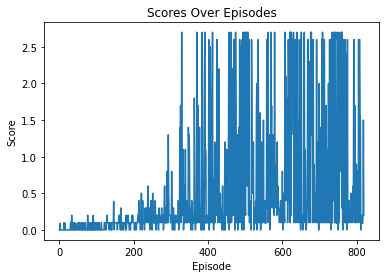

In [6]:
from src.utils import read_and_plot_scores_csv
rewards_path = "./ckpt/episodes_2500_max_t_500_sgd_epochs_4_batch_size_32_gradient_clip_2_ppo_clip_epsilon_0.1_lr_0.0003_weight_decay_0.0001/scores.csv"
read_and_plot_scores_csv(rewards_path)

# Ideas for future work



1. **Algorithm Enhancements:**
    - Investigate the application of advanced or variant algorithms like Trust Region Policy Optimization (TRPO) or Soft Actor-Critic (SAC). These algorithms might offer improvements in efficiency, stability, or performance compared to PPO.
2. **Hyperparameter Optimization:**
    - Conduct a thorough hyperparameter tuning exercise for the PPO algorithm. Using methods like grid search, random search, or Bayesian optimization can help in finding the optimal configuration that maximizes the performance in the Tennis environment.
3. **Multi-Agent Coordination Strategies:**
    - Develop and test new strategies for enhancing coordination between agents. This could involve shared learning techniques, where agents benefit from each other's experiences, or explicit communication protocols that allow agents to plan and execute cooperative strategies more effectively.
4. **Environment Complexity and Variability:**
    - Introduce new elements or variations to the Tennis environment, such as changing court conditions, obstacles, or introducing dynamic elements like variable wind patterns. These changes can test and improve the adaptability and robustness of your trained agents, ensuring they can handle a wider range of scenarios.